<a href="https://colab.research.google.com/github/FaisalAhmedBijoy/Awesome-pytorch-list/blob/master/Custom_DenseNet_Architecture_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import glob

## Mount Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
train_path='/content/drive/My Drive/CSE 4000 Thesis/Dataset1500/train'
test_path='/content/drive/My Drive/CSE 4000 Thesis/Dataset1500/test'

In [22]:
print(os.listdir(train_path))
print(os.listdir(test_path))

['building_house', 'mosque', 'temple', 'tinshed', 'mud_house', 'sky_building']
['mud_house', 'building_house', 'mosque', 'sky_building', 'temple', 'tinshed']


## Dataset Preparatin using ImageDataGenerator

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
WIDTH=224
HEIGHT=224

In [25]:
train_generator = ImageDataGenerator(rescale=1./255,
                                    #horizontal_flip=True,
                                    #shear_range=0.1 ,
                                    #zoom_range=0.1,
                                    #rotation_range=20,
                                    #height_shift_range=0.1,
                                    fill_mode='nearest',
                                    validation_split=0.2)
                                     
train_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT),
                                                 class_mode='categorical',
                                                 subset='training')

validation_dataset = train_generator.flow_from_directory(batch_size=32,
                                                 directory=train_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical',
                                                 subset='validation')

Found 960 images belonging to 6 classes.
Found 240 images belonging to 6 classes.


In [26]:
test_generator=ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(batch_size=32,
                                                 directory=test_path,
                                                 shuffle=True,
                                                 target_size=(WIDTH, HEIGHT), 
                                                 class_mode='categorical')

Found 300 images belonging to 6 classes.


In [27]:
train_dataset.class_indices

{'building_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'sky_building': 3,
 'temple': 4,
 'tinshed': 5}

In [28]:
validation_dataset.class_indices

{'building_house': 0,
 'mosque': 1,
 'mud_house': 2,
 'sky_building': 3,
 'temple': 4,
 'tinshed': 5}

In [29]:
total_class=len(train_dataset.class_indices)
print('Number of classes in dataset: ',total_class)

Number of classes in dataset:  6


## Plot some random image
- class 0: building house
- class 1: mosque
- class 2: mud house
- class 3: sky building
- class 4: temple
- class 5: tinshed

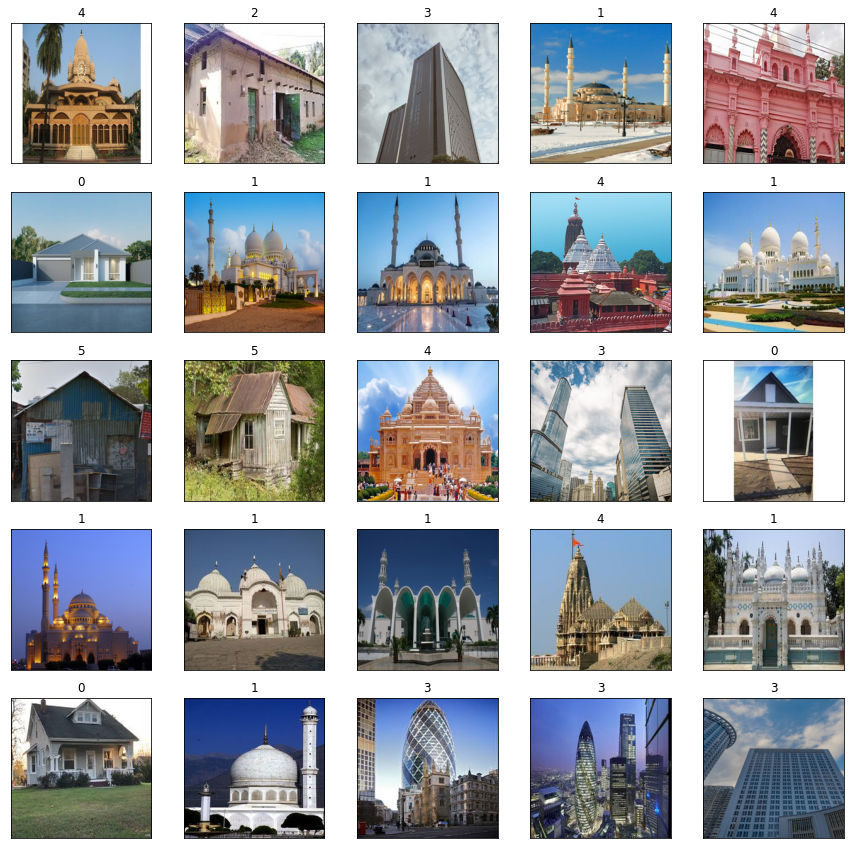

In [30]:
x,y=train_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

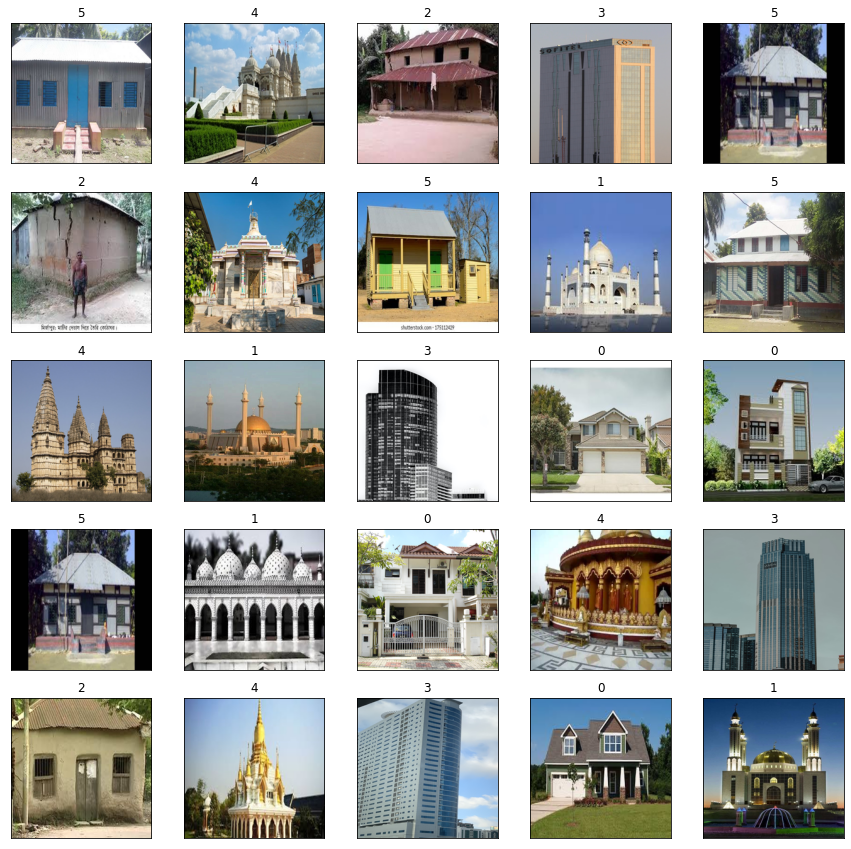

In [31]:
x,y=validation_dataset.next()
fig=plt.figure(figsize=(15,15))
rows=5
cols=5
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    image=x[i]
    plt.imshow(image)
    plt.title(np.argmax(y[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Import Library

In [32]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf


## BN ReLU Conv Function

In [33]:
def bn_rl_conv(x, filters, kernel_size):
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    return x


## Dense Block

In [34]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4*k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        tensor = layers.Concatenate()([tensor, x])
    return tensor


## Transition block

In [35]:
def transition_layer(x, theta):
    f = int(tf.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    x = layers.AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x


## Define Densene 

In [36]:
total_class=6
IMG_SHAPE = 224, 224, 3
k = 32
theta = 0.5
repetitions = 6, 12, 24, 16

input = layers.Input(IMG_SHAPE)

x = layers.Conv2D(2*k, 7, strides=2, padding='same')(input)
x = layers.MaxPool2D(3, strides=2, padding='same')(x)

for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)

x = layers.GlobalAvgPool2D()(d)

output = layers.Dense(total_class, activation='softmax')(x)




## Define Model

In [37]:
model = keras.Model(input, output)

## Analysis DenseNet Model

In [38]:
model.layers


In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_147[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 56, 56, 64)   256         max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [40]:
import time
print(time.time())

1622649164.9857798


In [41]:
t=time.time()
image_name='/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/DenseNet'+str(int(t))+'.png'
image_name

'/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/DenseNet1622649164.png'

In [42]:
t=time.time()
image_name='/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/DenseNet'+str(int(t))+'.png'
print(image_name)
keras.utils.plot_model(model,show_shapes=True,to_file=image_name)

/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/DenseNet1622649165.png
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.700524 to fit



In [43]:
## Compile The Model 

In [44]:
model.compile( loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Trained the Model

In [45]:
epochs=200
batch_size=32
trainset_length=len(train_dataset.labels)
validation_length=len(validation_dataset.labels)
steps_per_epoch=(trainset_length//batch_size)
validation_steps=(validation_length//batch_size)
print(trainset_length)
print(validation_length)
print(steps_per_epoch)
print(validation_steps)

960
240
30
7


In [46]:
history = model.fit(train_dataset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps)

Epoch 1/200
30/30 [==============================] - 455s 14s/step - loss: 2.4000 - accuracy: 0.3438 - val_loss: 20.6501 - val_accuracy: 0.1652
Epoch 2/200
30/30 [==============================] - 12s 409ms/step - loss: 1.4844 - accuracy: 0.4604 - val_loss: 14.1368 - val_accuracy: 0.1696
Epoch 3/200
30/30 [==============================] - 13s 415ms/step - loss: 1.4876 - accuracy: 0.4938 - val_loss: 180.2672 - val_accuracy: 0.2455
Epoch 4/200
30/30 [==============================] - 13s 423ms/step - loss: 1.2035 - accuracy: 0.5562 - val_loss: 15.1511 - val_accuracy: 0.2723
Epoch 5/200
30/30 [==============================] - 13s 422ms/step - loss: 1.1042 - accuracy: 0.5760 - val_loss: 2.0796 - val_accuracy: 0.3839
Epoch 6/200
30/30 [==============================] - 13s 415ms/step - loss: 0.9539 - accuracy: 0.6500 - val_loss: 2.9034 - val_accuracy: 0.3705
Epoch 7/200
30/30 [==============================] - 12s 409ms/step - loss: 0.9728 - accuracy: 0.6104 - val_loss: 1.9767 - val_accur

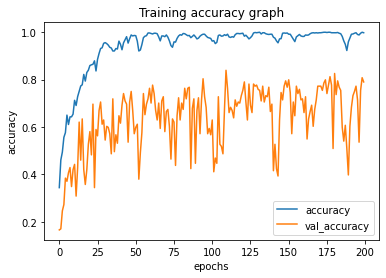

In [47]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training accuracy graph')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

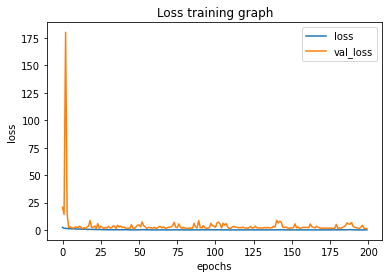

In [48]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss training graph')
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()


In [49]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print('Test Loss: ',test_loss)
print('Test Accuracy: ',test_accuracy)


10/10 [==============================] - 114s 13s/step - loss: 1.7724 - accuracy: 0.7800
Test Loss:  1.7723917961120605
Test Accuracy:  0.7799999713897705


## Saved Model

In [50]:
import time
t = time.time()

export_path_keras = "/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/DenseNet{}_model_{}.h5".format(test_accuracy,int(t))
print(export_path_keras)
model.save(export_path_keras)

/content/drive/MyDrive/CSE 4000 Thesis/Complex DNN Architecture/DenseNet0.7799999713897705_model_1622652339.h5


In [51]:
from tensorflow.keras.models import load_model

In [52]:
model_path=export_path_keras
reload_model=load_model(model_path)
reload_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_147[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 56, 56, 64)   256         max_pooling2d_3[0][0]            
____________________________________________________________________________________________